In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

In [11]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

# Train on all OSM classes

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-01 16:17:59.260 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-01 16:18:02.679 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-01 16:18:02.680 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-01 16:18:03.057 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-01 16:18:03.726 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-01 16:18:03.726 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [3]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

---

In [4]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.16786 params 0.0364581
epoch   1 step 3662 loss 0.15898 params 0.0535343
epoch   2 step 3662 loss 0.15218 params 0.0776345
epoch   3 step 3662 loss 0.15730 params 0.1023680
epoch   4 step 3662 loss 0.14771 params 0.1271909
epoch   5 step 3662 loss 0.14300 params 0.1523066
epoch   6 step 3662 loss 0.15111 params 0.1779782
epoch   7 step 3662 loss 0.13661 params 0.2040961
epoch   8 step 3662 loss 0.14101 params 0.2305158
epoch   9 step 3662 loss 0.14393 params 0.2568380
epoch  10 step 3662 loss 0.13020 params 0.2834253
epoch  11 step 3662 loss 0.13871 params 0.3100521
epoch  12 step 3662 loss 0.13755 params 0.3365520
epoch  13 step 3662 loss 0.13815 params 0.3630856
epoch  14 step 3662 loss 0.13850 params 0.3896684
epoch  15 step 3662 loss 0.13435 params 0.4162102
epoch  16 step 3662 loss 0.14209 params 0.4428231
epoch  17 step 3662 loss 0.13348 params 0.4693492
epoch  18 step 3662 loss 0.13848 params 0.4956720
epoch  19 step 3662 loss 0.14292 params 0.5217057


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

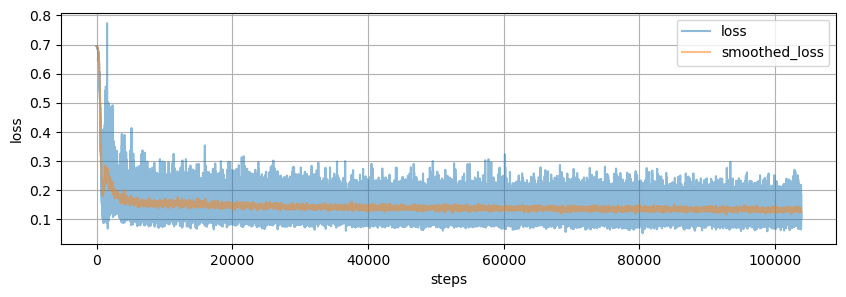

In [5]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [6]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:13 Time:  0:00:130001


((58599, 99), (58599, 99))

In [7]:
idxs = np.random.permutation(len(targets))[:300]

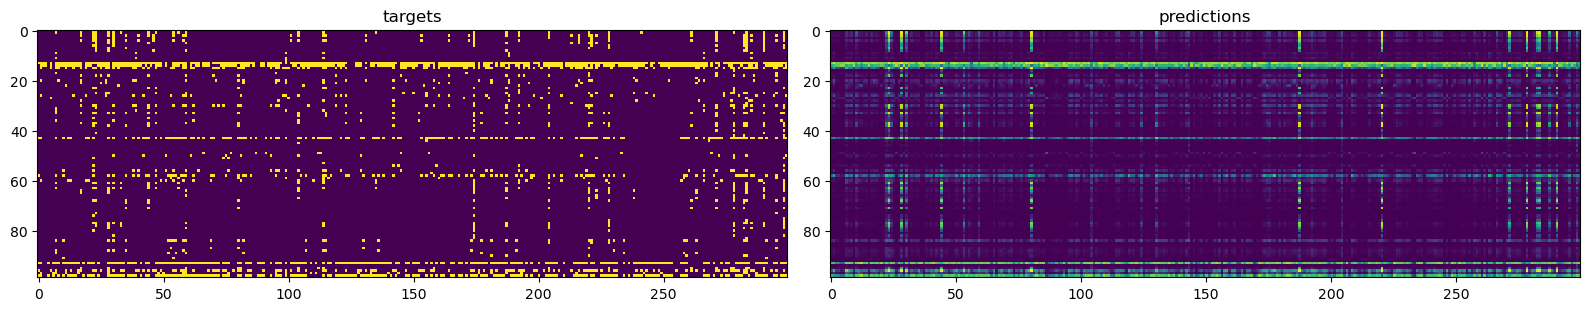

In [8]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [9]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred),
                               'prec': prec(y_true, y_pred)}

In [10]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5049786837131849, 'prec': 0.7197817113661834}

In [11]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.7197817113661834, 0.5049786837131849)

In [12]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

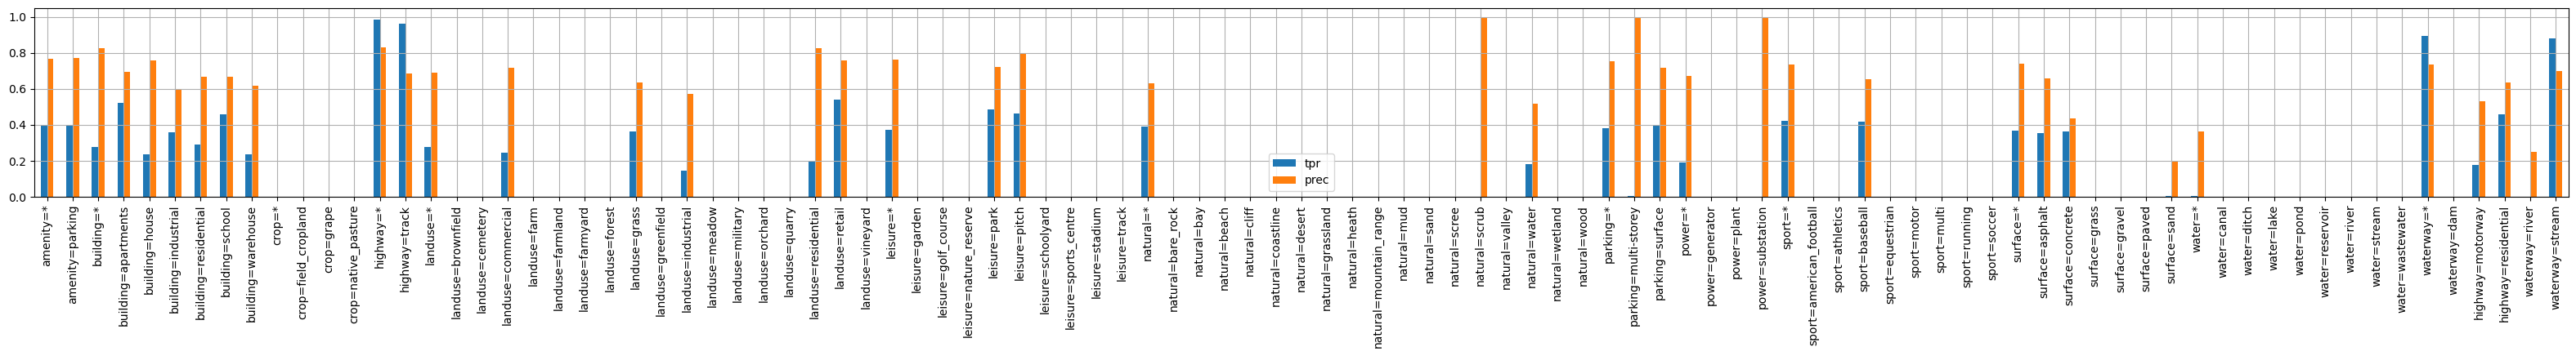

In [13]:
ax = r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()
ax.set_xticklabels(labels=(name_dict[i] for i in range(99)), rotation=90, fontsize=10);

In [ ]:
# classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13,
#                   14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
#                   38, 43, 58, 61, 63, 64, 68, 71, 77, 78,
#                   87, 93, 95, 96, 98]

In [ ]:
# ax = r[['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(10,10))

# for i in range(len(np.array(r.tpr))):
#     if not np.isnan(np.array(r.prec)[i]):
#         ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=name_dict[list(r.index)[i]], size=10)

---

In [14]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:01:35 Time:  0:01:350008


(100, 99, 2)

In [ ]:
# fig = plt.figure(figsize=(10, 2));
# # print(targets[:, c].sum())
# c = 1
# plt.hist(predictions[:, c], bins=100);
# plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
# plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
# plt.yscale('log'); plt.xlabel('prediction prob'); plt.xlim(0,1);

# i_nz = (R[:, c, 1] >= .8).nonzero()[0][0]
# plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');

Classes to retain based on the below

In [2]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  93, 95, 96, 97, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

25
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
97 waterway=river
98 waterway=stream


<Figure size 640x480 with 0 Axes>

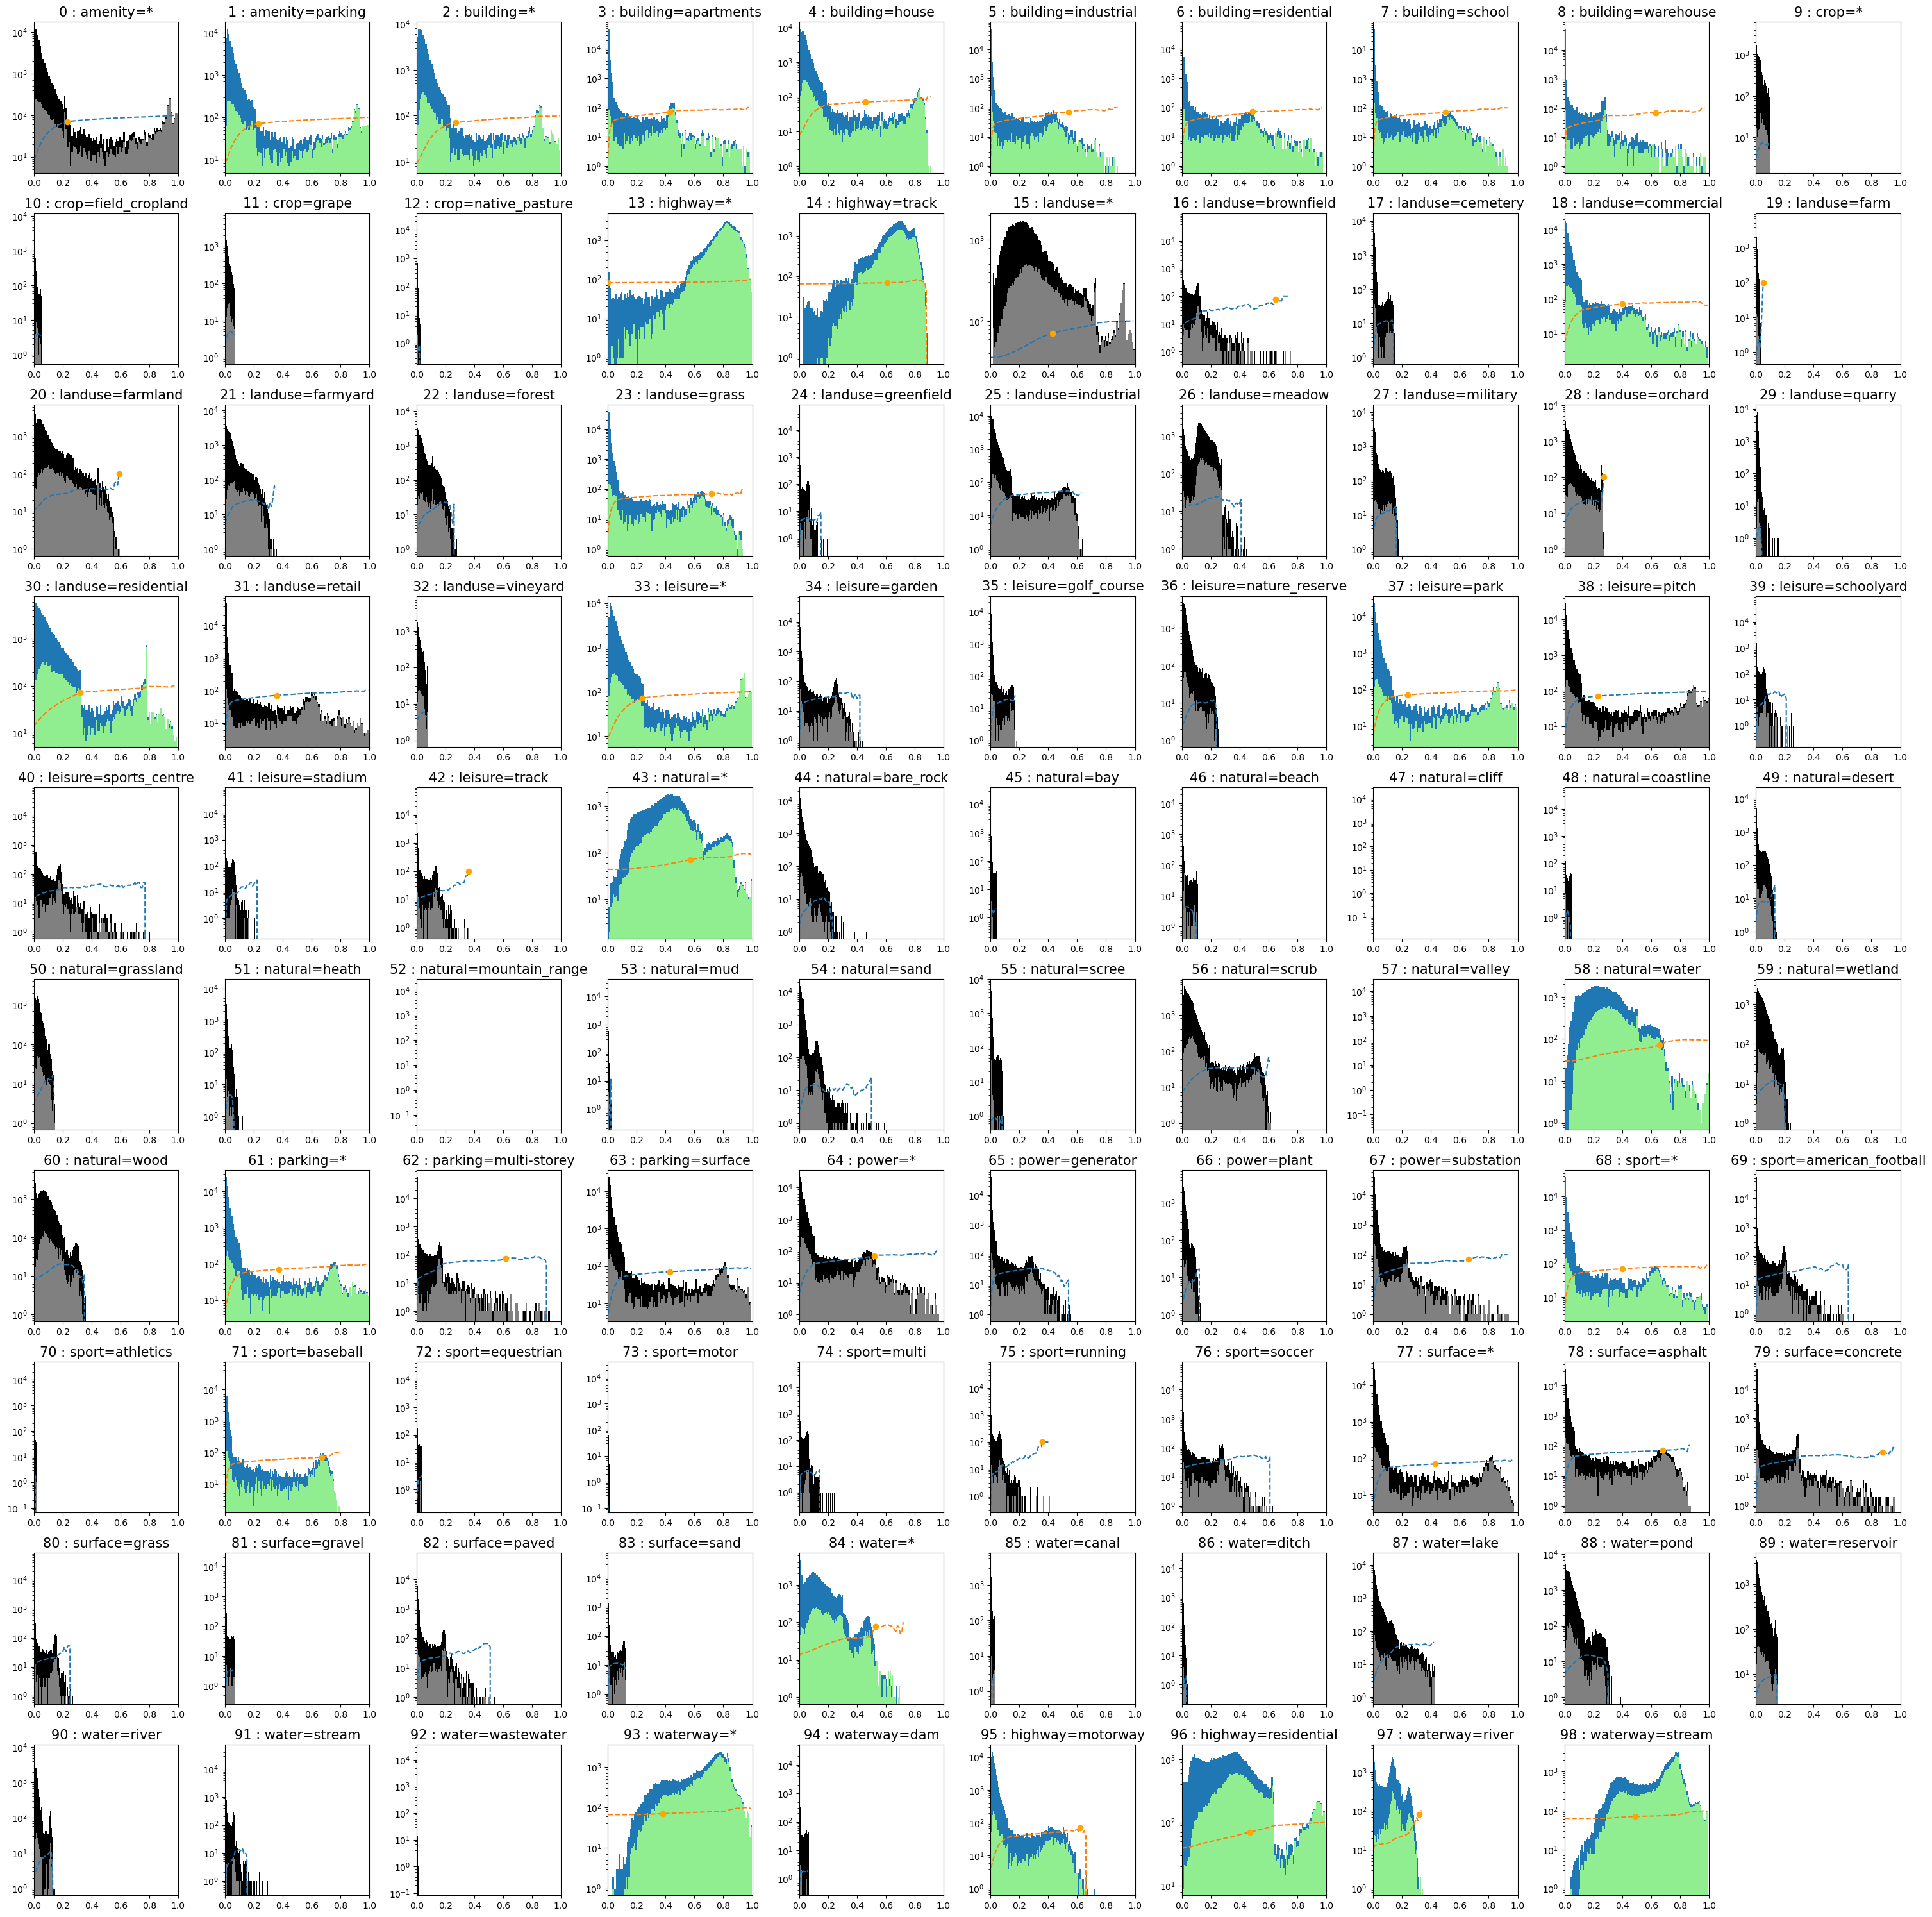

In [265]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

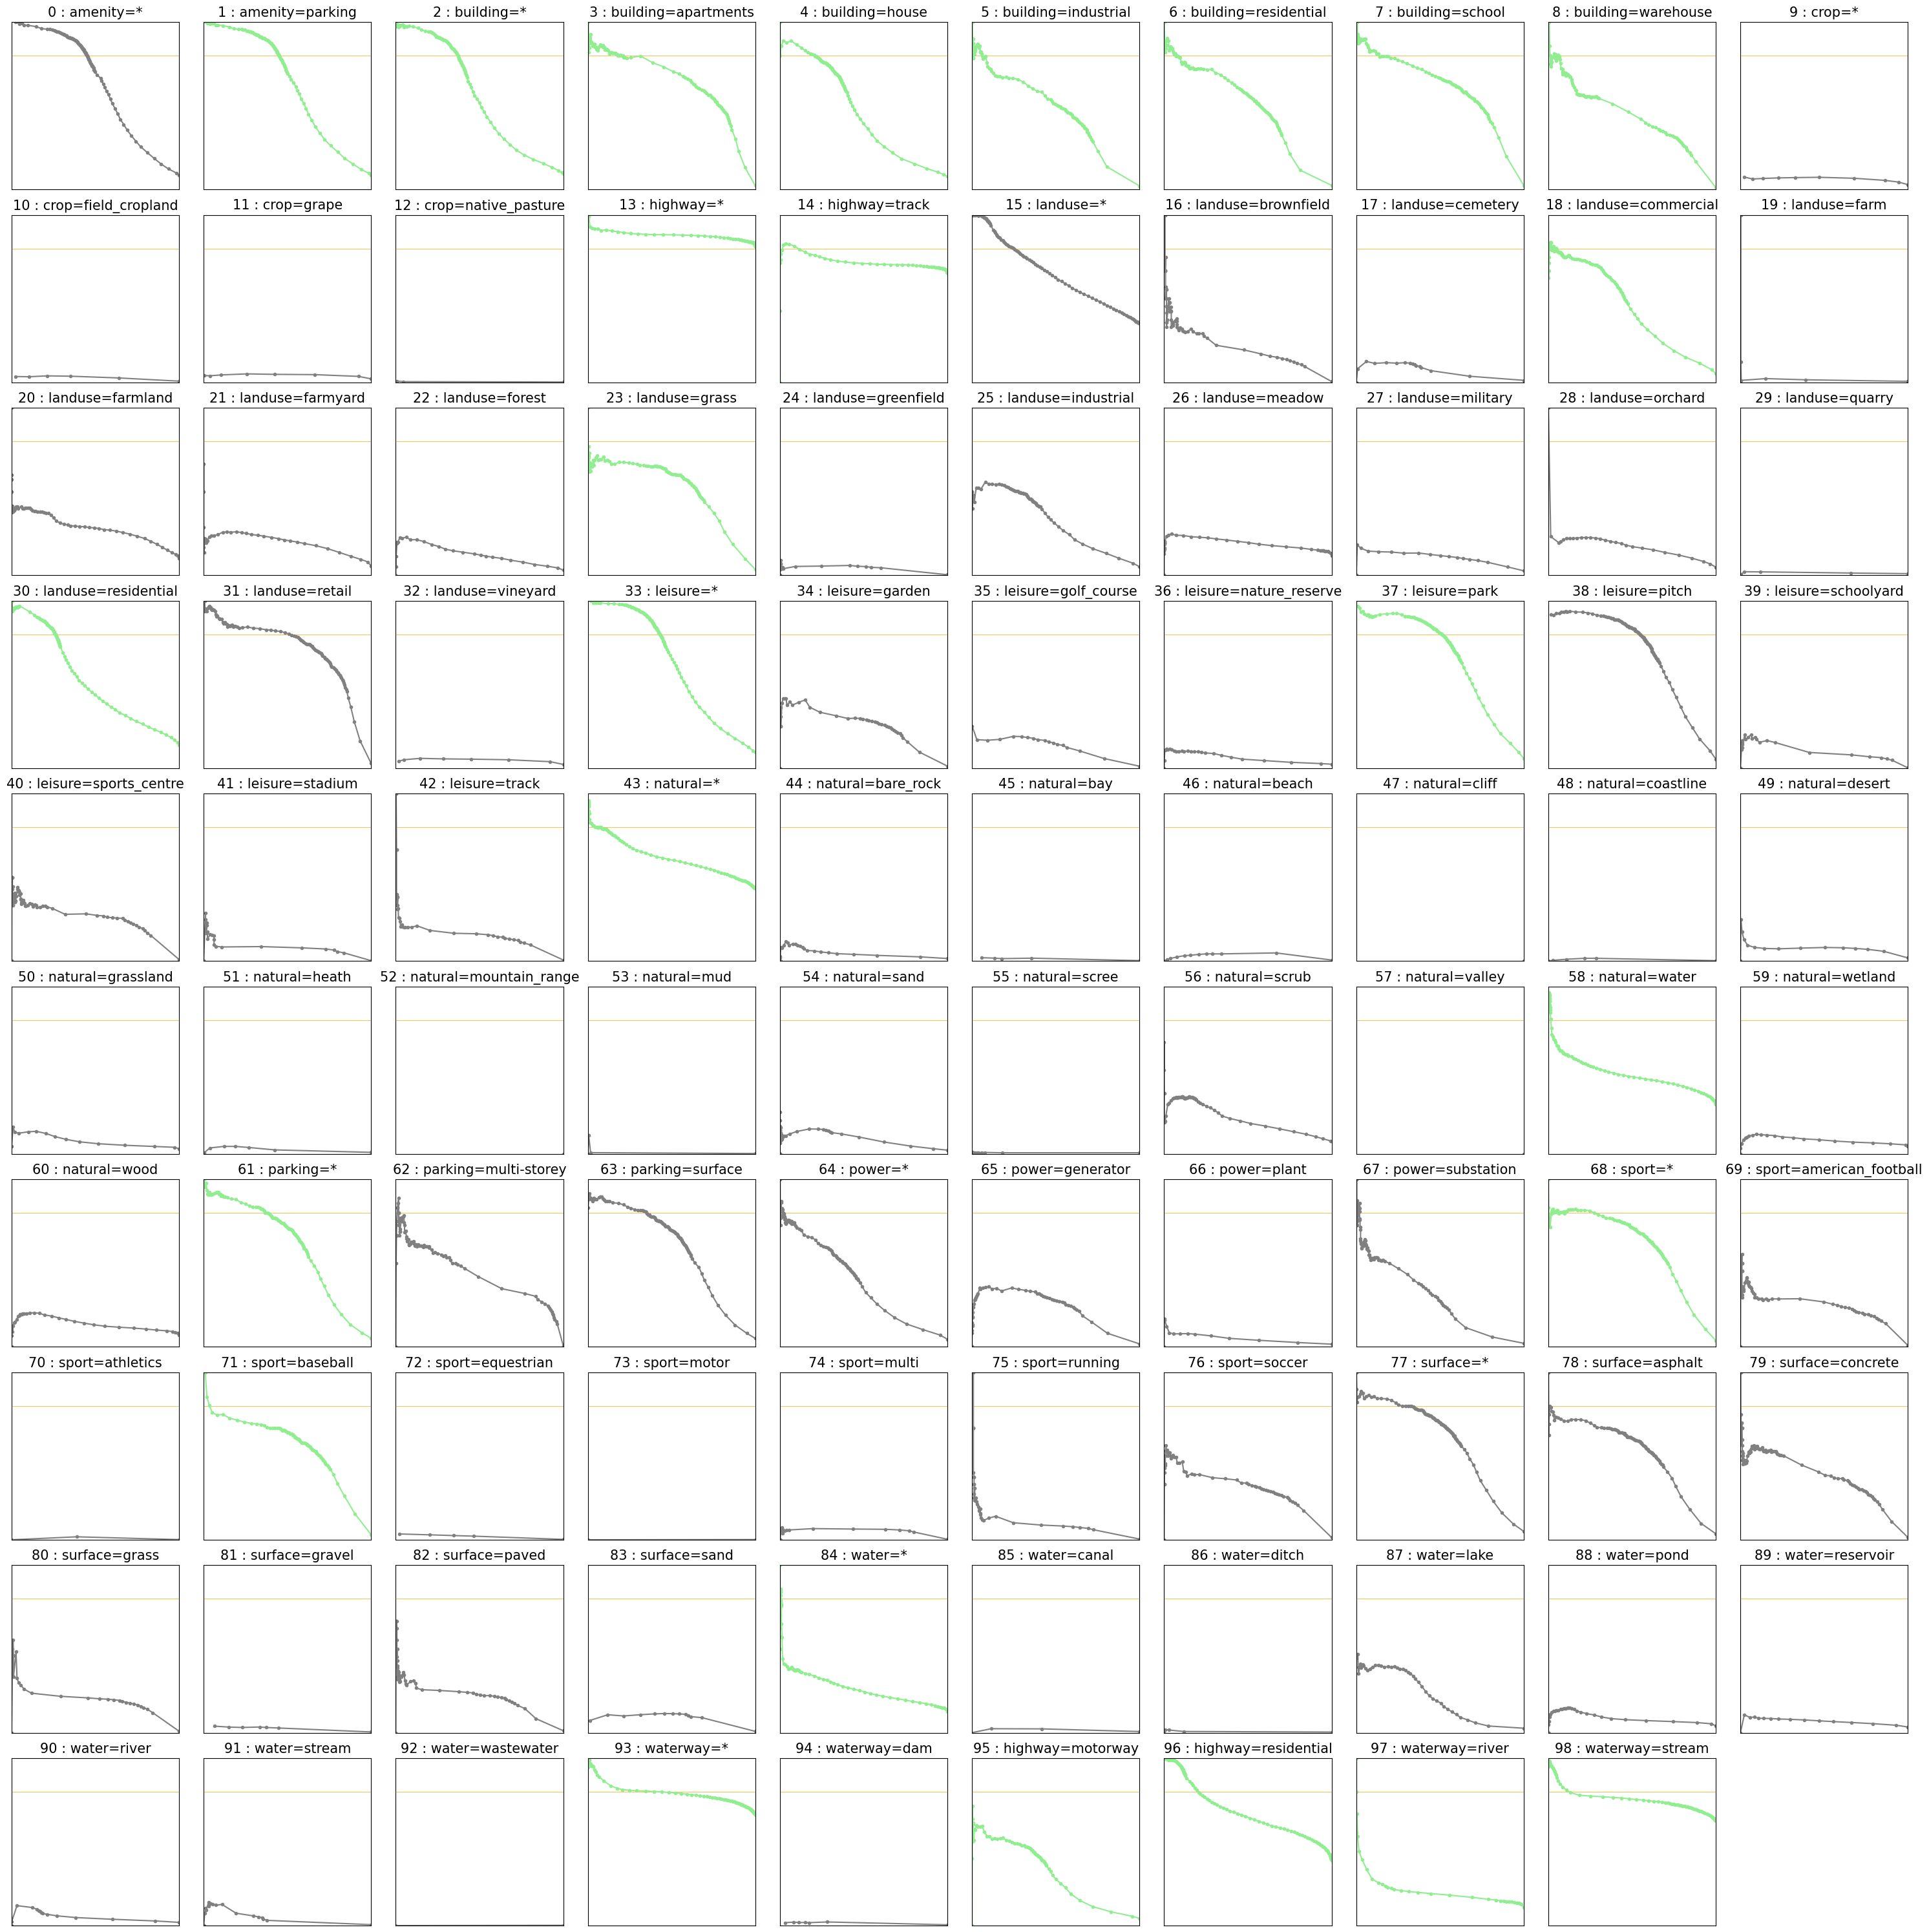

In [266]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [19]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .3)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

25
{2: 0.1, 3: 0.04, 4: 0.12, 5: 0.07, 6: 0.08, 7: 0.05, 8: 0.1, 13: 0.0, 14: 0.0, 18: 0.11, 23: 0.07, 30: 0.16, 33: 0.11, 37: 0.08, 43: 0.0, 58: 0.02, 61: 0.07, 68: 0.06, 71: 0.06, 84: 0.25, 93: 0.0, 95: 0.1, 96: 0.0, 97: 0.3, 98: 0.0}


---

# Retrain only on retained classes

In [3]:
for c in classes_retain:
    print(name_dict[c])

building=*
building=apartments
building=house
building=industrial
building=residential
building=school
building=warehouse
highway=*
highway=track
landuse=commercial
landuse=grass
landuse=residential
leisure=*
leisure=park
natural=*
natural=water
parking=*
sport=*
sport=baseball
water=*
waterway=*
highway=motorway
highway=residential
waterway=river
waterway=stream


In [4]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-01 17:09:57.416 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-01 17:10:00.785 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-05-01 17:10:00.785 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-01 17:10:01.160 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-01 17:10:01.830 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-05-01 17:10:01.831 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-05-

In [5]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561177

In [6]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.32150 params 0.0361692
epoch   1 step 3662 loss 0.31387 params 0.0525175
epoch   2 step 3662 loss 0.31898 params 0.0733088
epoch   3 step 3662 loss 0.30052 params 0.0957162
epoch   4 step 3662 loss 0.29082 params 0.1194798
epoch   5 step 3662 loss 0.28953 params 0.1436837
epoch   6 step 3662 loss 0.30033 params 0.1677673
epoch   7 step 3662 loss 0.28910 params 0.1926727
epoch   8 step 3662 loss 0.29555 params 0.2172232
epoch   9 step 3662 loss 0.27657 params 0.2412954
epoch  10 step 3662 loss 0.28102 params 0.2653261
epoch  11 step 3662 loss 0.28271 params 0.2891650
epoch  12 step 3662 loss 0.28584 params 0.3129776
epoch  13 step 3662 loss 0.27260 params 0.3371596
epoch  14 step 3662 loss 0.27854 params 0.3613806
epoch  15 step 3662 loss 0.27675 params 0.3858145
epoch  16 step 3662 loss 0.26465 params 0.4104019
epoch  17 step 3662 loss 0.25782 params 0.4350547
epoch  18 step 3662 loss 0.26790 params 0.4601314
epoch  19 step 3662 loss 0.27879 params 0.4856562


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



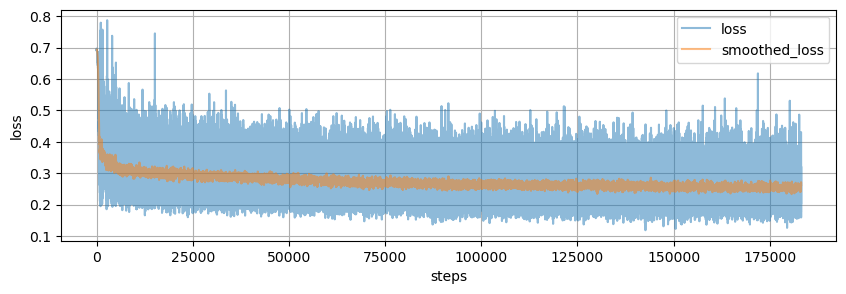

In [7]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [8]:
targets = []
predictions = []
embeddings = []
dltrain = dl.train_dataloader()
# dltrain = dl.test_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]

    o = m(x)

    for xi in x.detach().numpy():
        embeddings.append(xi)
    
    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)

embeddings = np.r_[embeddings]
targets = np.r_[targets]
predictions = np.r_[predictions]
embeddings.shape, targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:14 Time:  0:00:140001


((58599, 768), (58599, 25), (58599, 25))

In [9]:
idxs = np.random.permutation(len(targets))[:300]

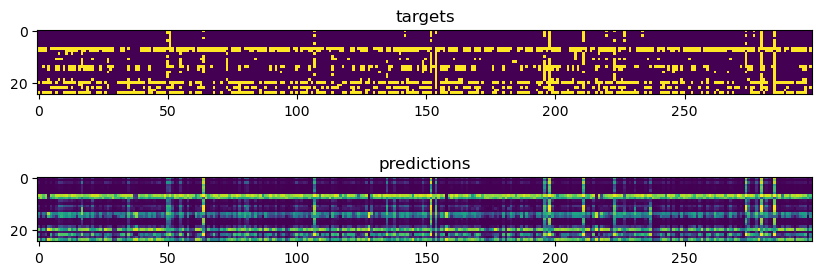

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

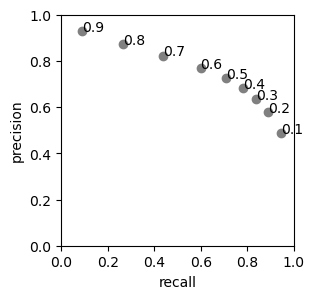

In [12]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets.flatten(), predictions.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [13]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:330003


(100, 25, 2)

<Figure size 640x480 with 0 Axes>

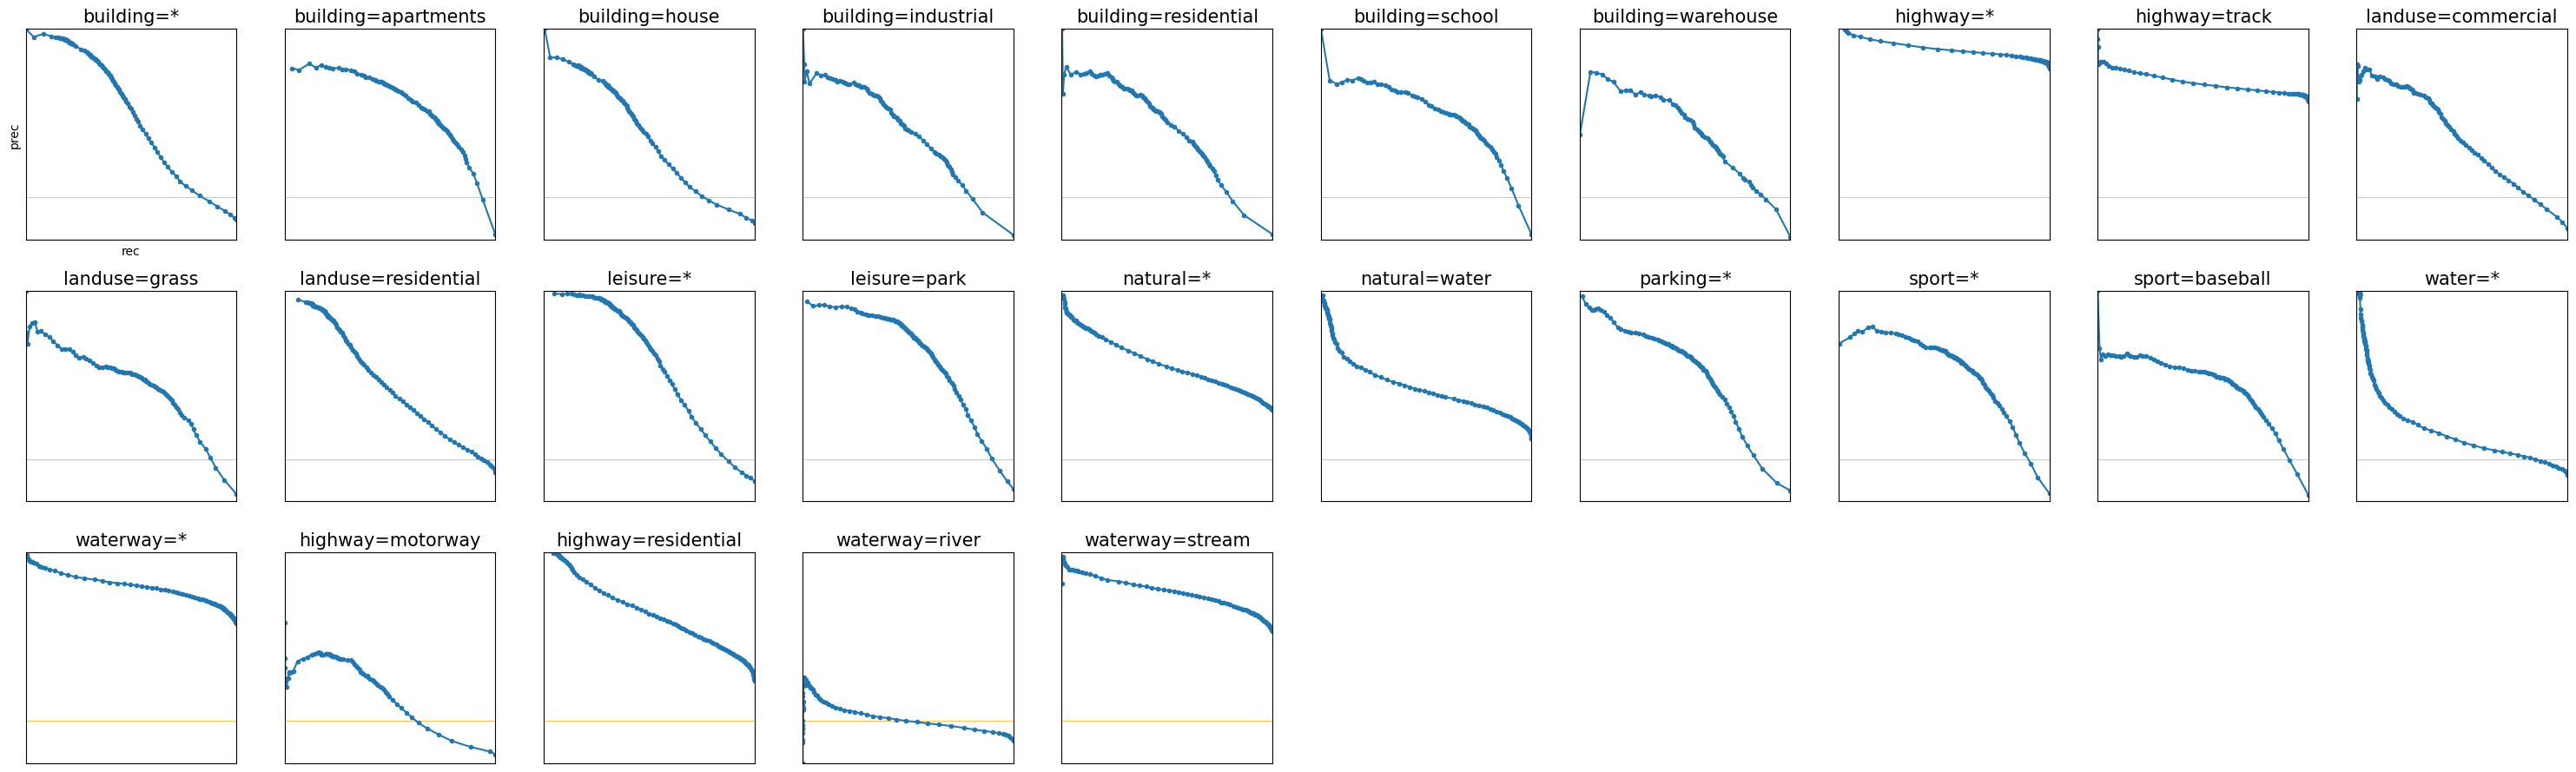

In [14]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.2,.2], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R[i, c, :] and np.isfinite(list(R[i, c, :])).all():
    #         ax.text(*R[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

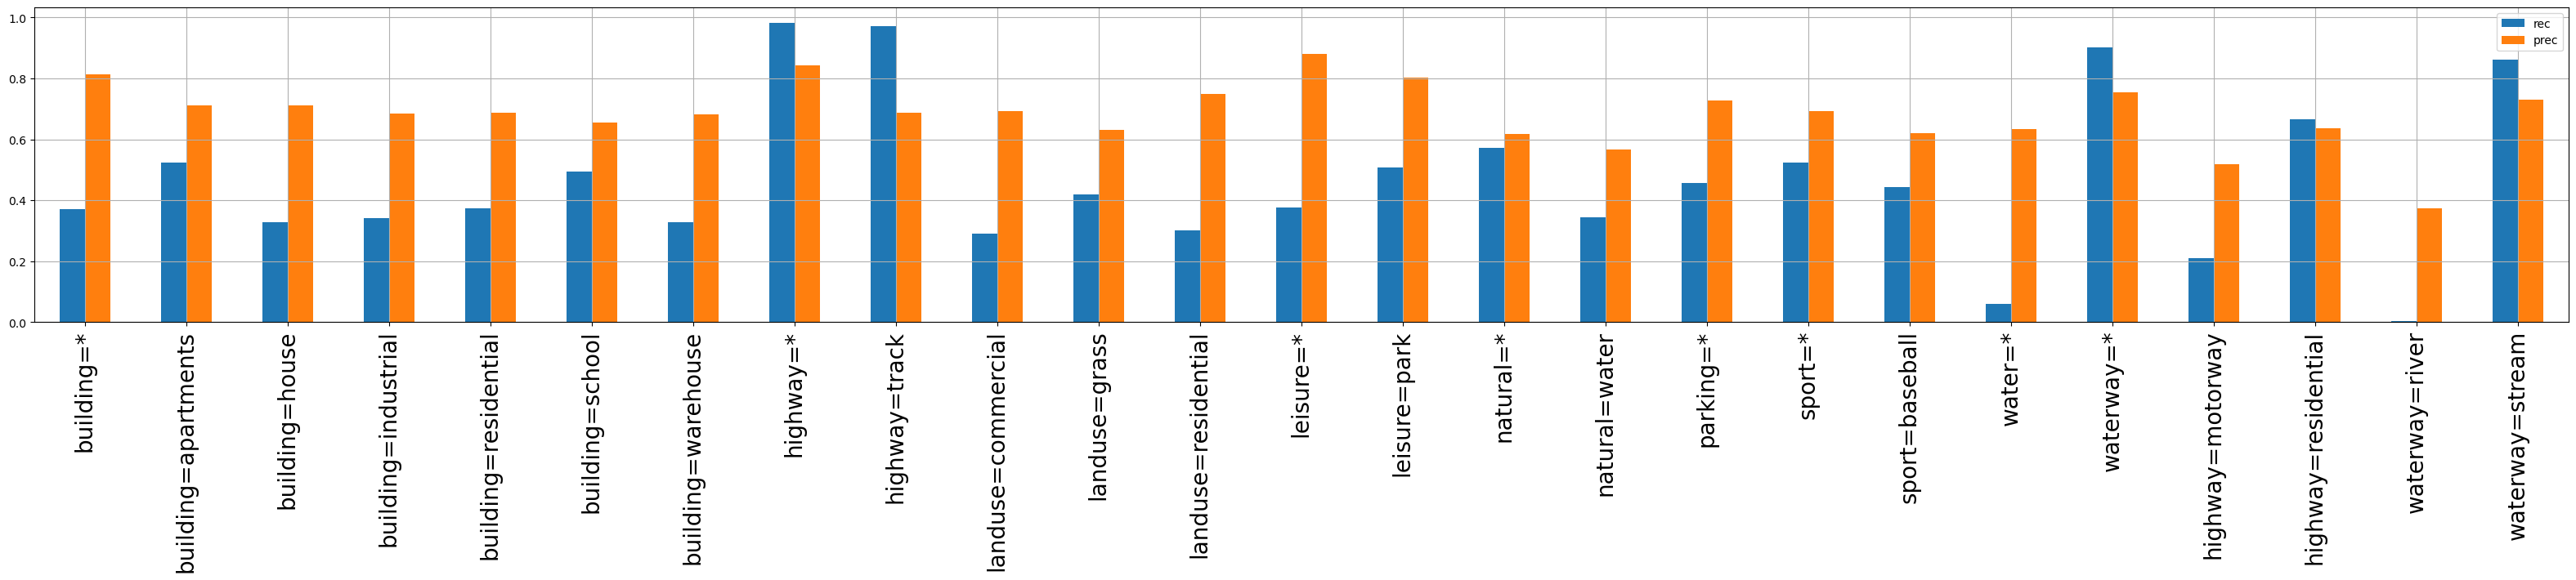

In [15]:
ax = pd.DataFrame(R[50], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[classes_retain[i]] for i in range(len(classes_retain))), rotation=90, fontsize=20);

In [17]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R[:, i, 1] >= .4)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for i, c in enumerate(prob_cutoff):
    i_alter = (predictions[:, i] < prob_cutoff[c])
    targets2[i_alter, i] = 0

25
{2: 0.15, 3: 0.08, 4: 0.17, 5: 0.17, 6: 0.15, 7: 0.08, 8: 0.14, 13: 0.0, 14: 0.0, 18: 0.18, 23: 0.11, 30: 0.21, 33: 0.12, 37: 0.09, 43: 0.0, 58: 0.22, 61: 0.08, 68: 0.08, 71: 0.1, 84: 0.29, 93: 0.0, 95: 0.23, 96: 0.02, 97: 0.48, 98: 0.0}


<Figure size 640x480 with 0 Axes>

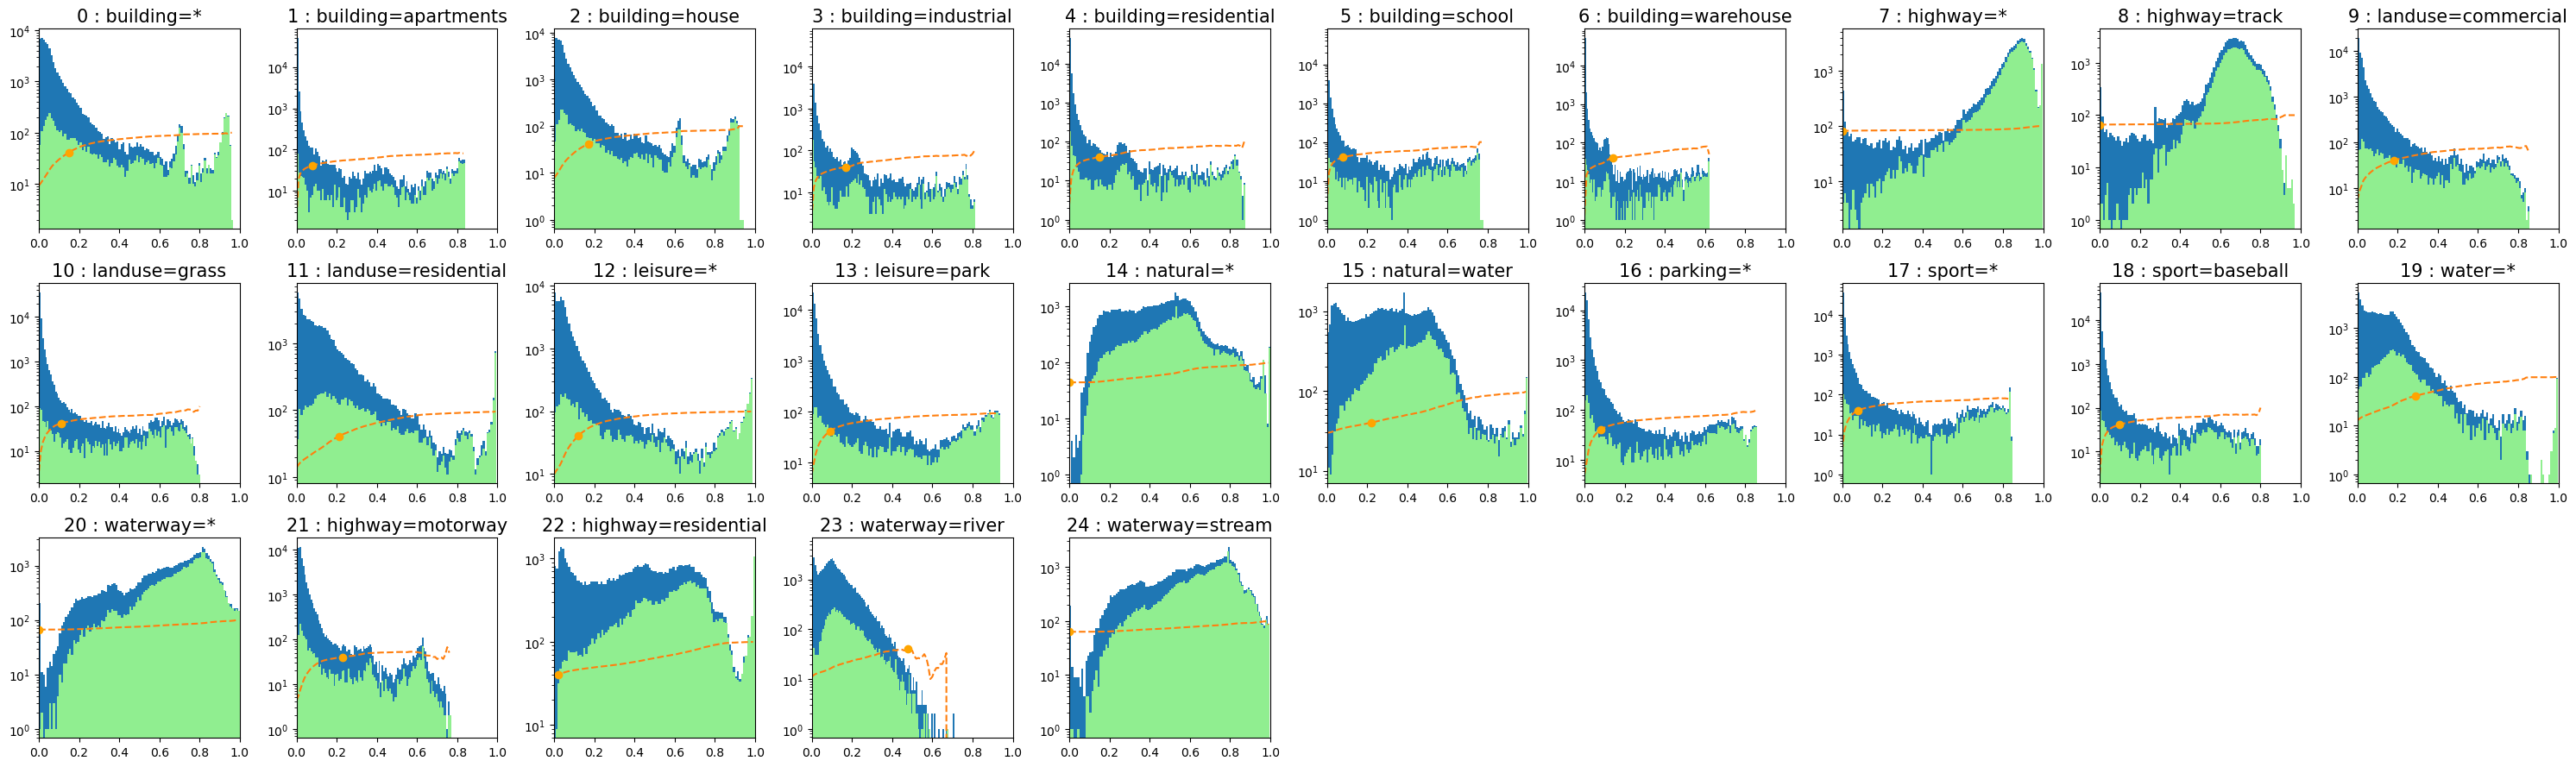

In [18]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions[:, c], bins=100);
    plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .4)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[classes_retain[c]]}", fontsize=15);

# Retrain on retained classes and modified targets

Modify the labels for instances of low precision

In [21]:
targets2.shape

(58599, 25)

In [24]:
# Full-dataset batch
X = torch.Tensor(embeddings)
T = torch.Tensor(targets2)
# for batch in pbar(dltrain):
#     x = batch['embedding']
#     X = torch.concat([X, x])
#     t = batch['multilabel'][:, classes_retain]
#     T = torch.concat([T, t])

X.shape, T.shape

(torch.Size([58599, 768]), torch.Size([58599, 25]))

In [42]:
m2 = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m2.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m2.parameters()])

561177

In [43]:
n_epochs = 100

bs = 16
lossh = []
for epoch in range(n_epochs):
    for step, ix in enumerate(list(range(0, len(X)-bs, bs))):
        x = X[ix:ix+bs]
        t = T[ix:ix+bs]

        # run model
        o = m2(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()

        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m2.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")

    print()

epoch   0 step 3661 loss 0.25873 params 0.0357539
epoch   1 step 3661 loss 0.23505 params 0.0521609
epoch   2 step 3661 loss 0.22825 params 0.0729944
epoch   3 step 3661 loss 0.22735 params 0.0952127
epoch   4 step 3661 loss 0.22766 params 0.1189654
epoch   5 step 3661 loss 0.21894 params 0.1432590
epoch   6 step 3661 loss 0.21503 params 0.1681034
epoch   7 step 3661 loss 0.21476 params 0.1935131
epoch   8 step 3661 loss 0.21392 params 0.2190335
epoch   9 step 3661 loss 0.21191 params 0.2441994
epoch  10 step 3661 loss 0.21352 params 0.2694849
epoch  11 step 3661 loss 0.21092 params 0.2949093
epoch  12 step 3661 loss 0.20819 params 0.3201316
epoch  13 step 3661 loss 0.20695 params 0.3451735
epoch  14 step 3661 loss 0.20598 params 0.3697763
epoch  15 step 3661 loss 0.20428 params 0.3939211
epoch  16 step 3661 loss 0.20358 params 0.4178593
epoch  17 step 3661 loss 0.20295 params 0.4412916
epoch  18 step 3661 loss 0.20346 params 0.4647541
epoch  19 step 3661 loss 0.20017 params 0.4879118


Text(0, 0.5, 'loss')

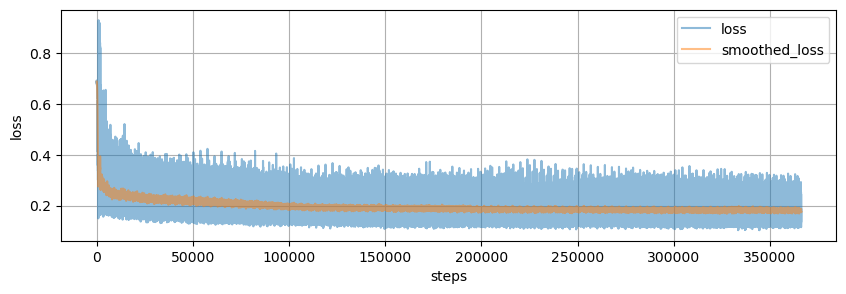

In [45]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [46]:
predictions2 = m2(X).detach().numpy()
targets2.shape, predictions2.shape

((58599, 25), (58599, 25))

In [47]:
idxs = np.random.permutation(len(T))[:300]

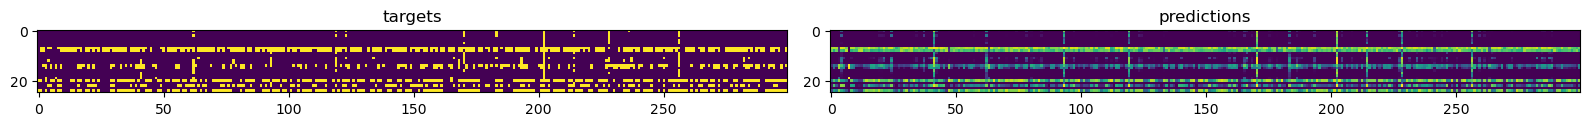

In [48]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets2[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions2[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

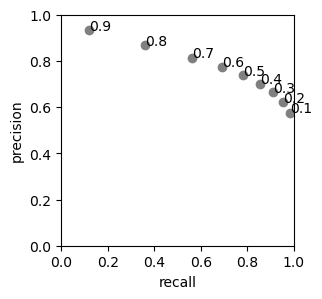

In [49]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets2.flatten(), predictions2.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [50]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets2[:,c], predictions2[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:330003


(100, 25, 2)

<Figure size 640x480 with 0 Axes>

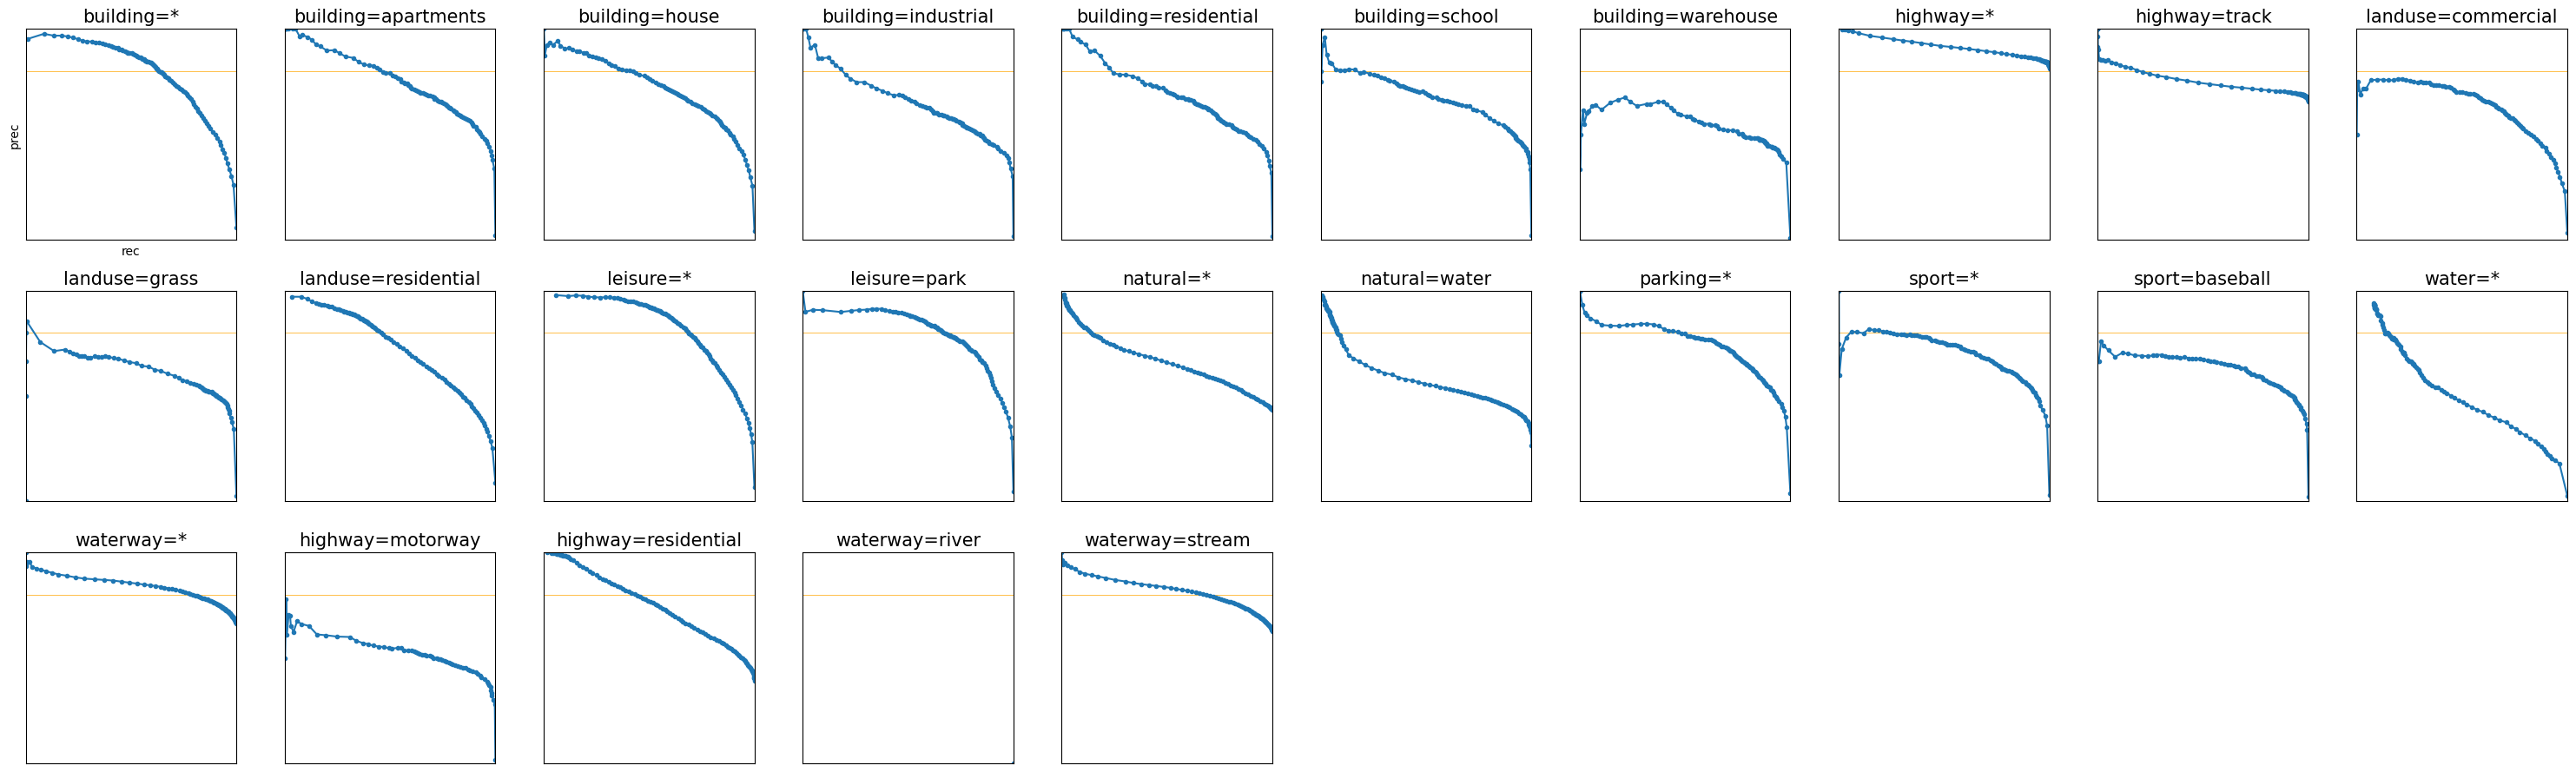

In [51]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
plt.tight_layout();

---

Before

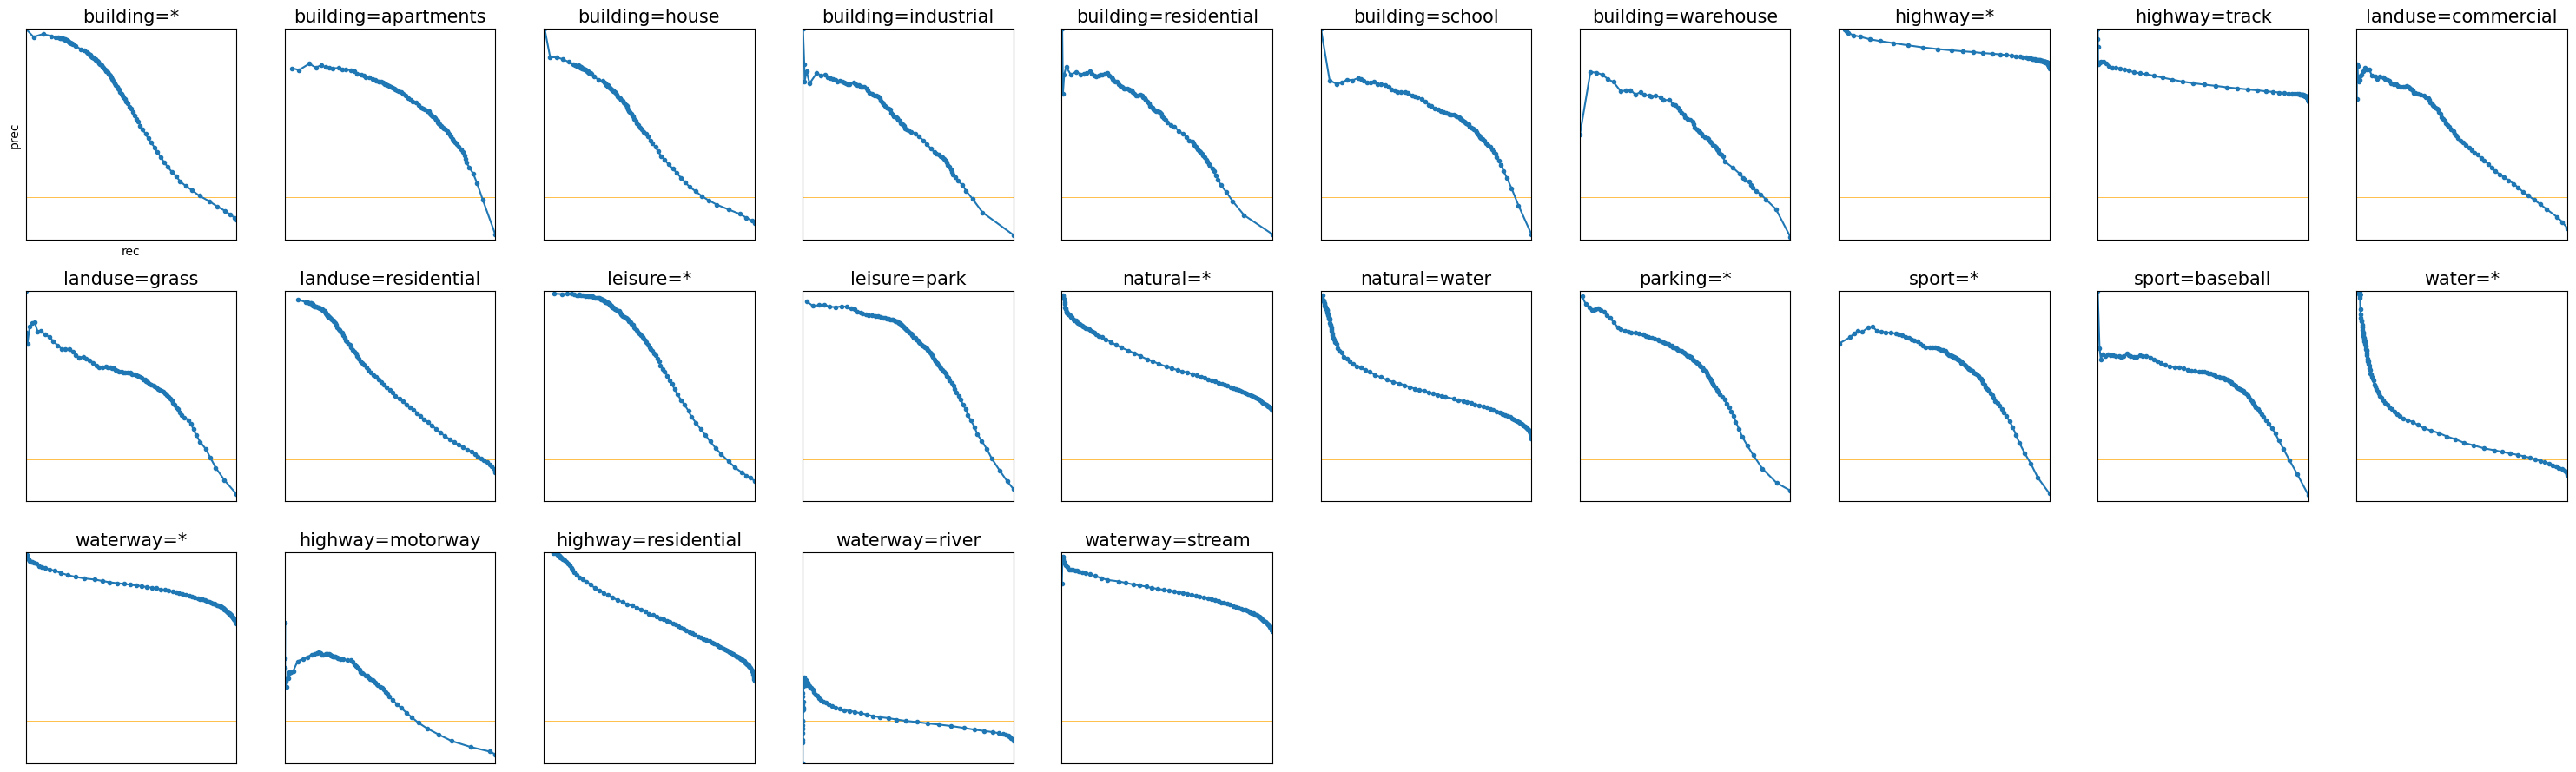


After 

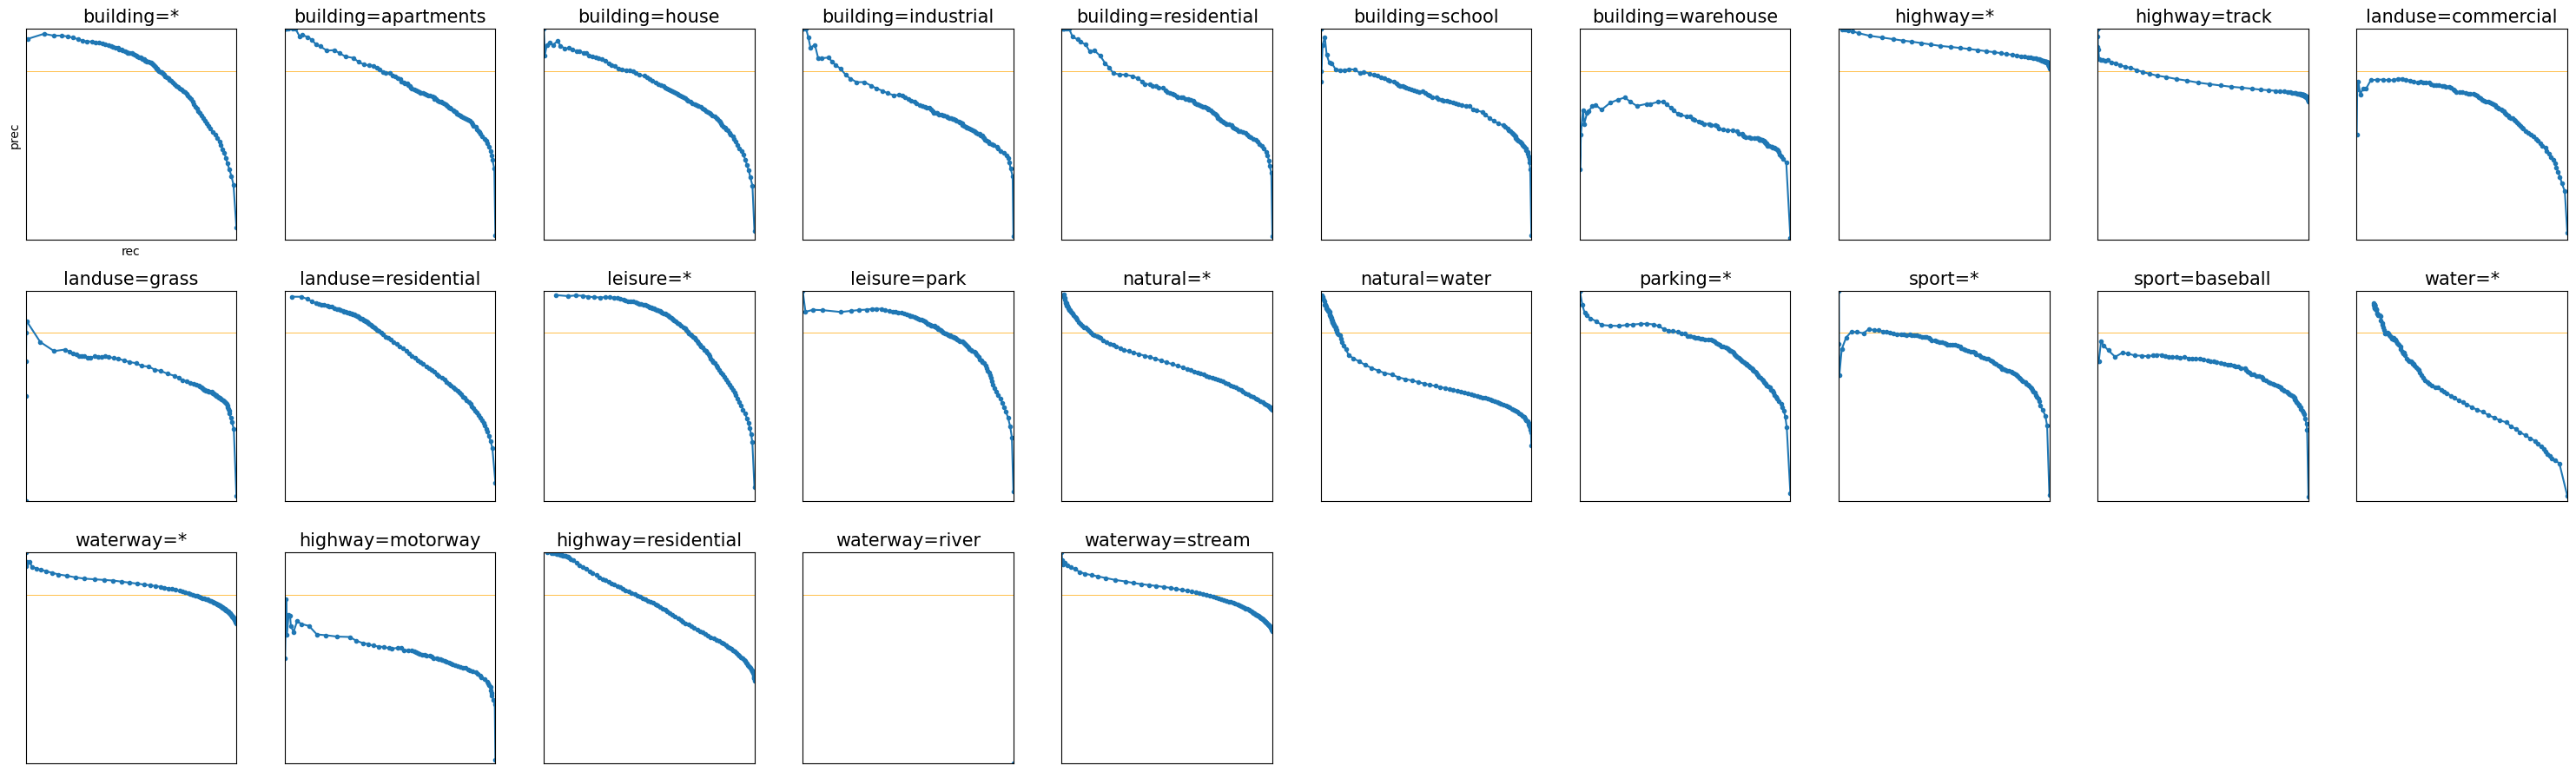

---

<Figure size 640x480 with 0 Axes>

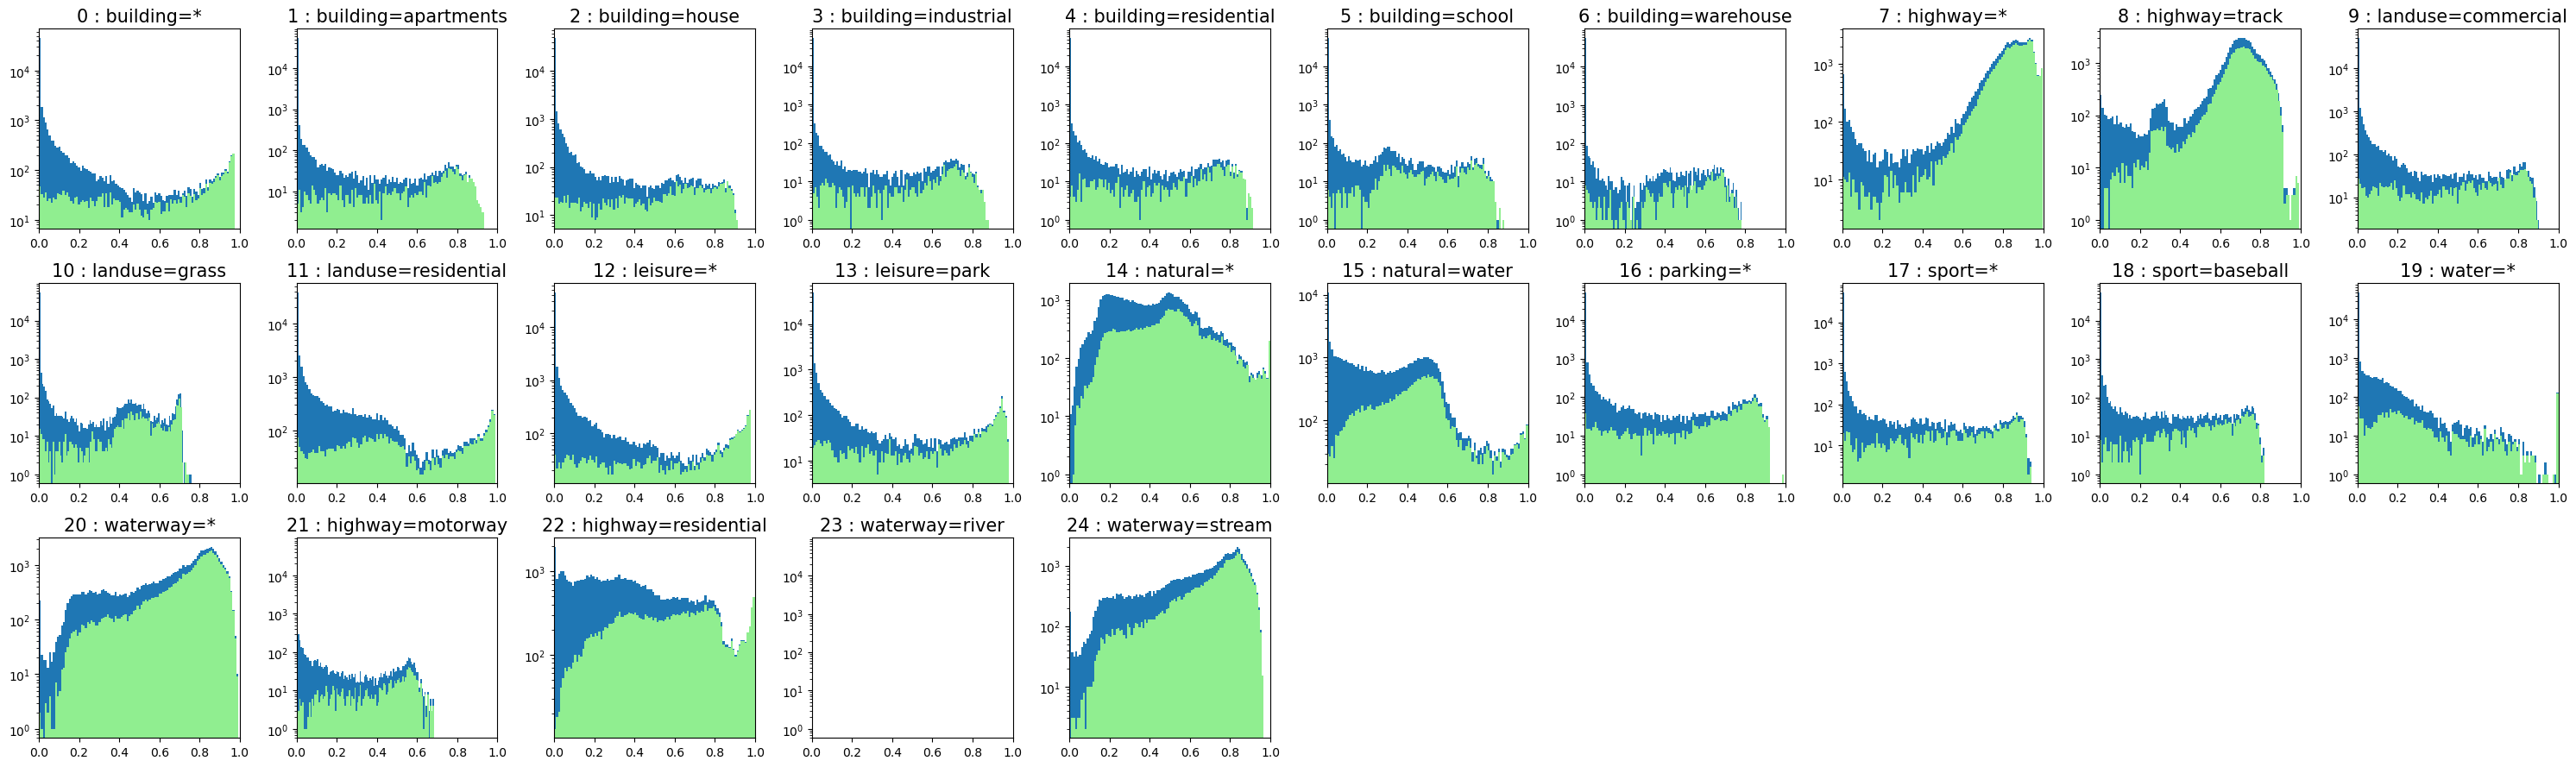

In [56]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=10, usizex=3, usizey=3):
    plt.hist(predictions2[:, c], bins=100);
    plt.hist(predictions2[targets2[:, c] > 0, c], bins=100, color='lightgreen');
    # plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    # is_high_prec = (R[:, c, 1] >= .4)
    # if is_high_prec.sum() > 0:
    #     i_nz = is_high_prec.nonzero()[0][0]
    #     plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[classes_retain[c]]}", fontsize=15);